In [ ]:
!pip install -r /content/unet-requirements.txt
!pip3 install -U segmentation-models

     |████████████████████████████████| 1.9 MB 9.1 MB/s 
     |████████████████████████████████| 890 kB 32.3 MB/s 
     |████████████████████████████████| 155 kB 39.5 MB/s 
     |████████████████████████████████| 4.1 MB 31.7 MB/s 
     |████████████████████████████████| 4.1 MB 12.2 MB/s 
     |████████████████████████████████| 889 kB 34.0 MB/s 
     |████████████████████████████████| 61 kB 6.6 MB/s 
     |████████████████████████████████| 3.3 MB 31.9 MB/s 
     |████████████████████████████████| 126 kB 43.0 MB/s 
     |████████████████████████████████| 792 kB 44.1 MB/s 
     |████████████████████████████████| 129 kB 47.5 MB/s 
     |████████████████████████████████| 86 kB 5.6 MB/s 
     |████████████████████████████████| 1.3 MB 31.4 MB/s 
     |████████████████████████████████| 13.3 MB 30.7 MB/s 
     |████████████████████████████████| 11.2 MB 34.8 MB/s 
     |████████████████████████████████| 146 kB 49.1 MB/s 
     |████████████████████████████████| 9.5 MB 33.6 MB/s 
     |███████████

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
import glob
import random
import warnings #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
seed = 42

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [ ]:
traindir = glob.glob(r'/content/drive/MyDrive/train_npy/*')

In [ ]:
images = []
masks = []
for i in range(len(traindir)):
    if 'seg' in traindir[i]:
        a = np.load(traindir[i])
        masks.append(a)
    else:
        a = np.load(traindir[i])
        images.append(a)
print(len(images), len(masks))

del masks[0:6]
len(images) == len(masks)

1746 1752


True

In [ ]:
train_img = np.zeros((len(images), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
train_msk = np.zeros((len(masks), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
for i in range(len(images)):
    images[i] = images[i].reshape((images[i].shape[0], images[i].shape[1], 1))
    img = images[i][:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range= True)
    #img = img.reshape(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    train_img[i] = img

for i in range(len(masks)):
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    mask_ = masks[i]
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)
    train_msk[i] = mask

In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')
BACKBONE = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE)

Segmentation Models: using `keras` framework.


In [ ]:
train_img = preprocess_input1(train_img)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_img, train_msk, test_size = 0.25, random_state = 42)
print(X_train.shape)
print(X_test.shape)

(1309, 128, 128, 3)
(437, 128, 128, 3)


In [ ]:
seed=24
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

In [ ]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
print(model.summary())

2022-03-02 13:36:31.257857: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


85532672/85521592 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                           

In [ ]:
history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=50, validation_steps=50, epochs=20, verbose=1)

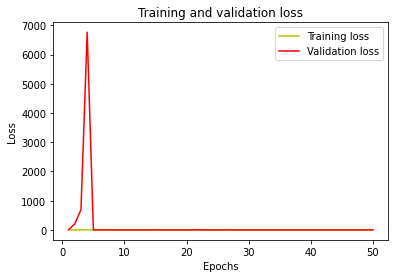

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

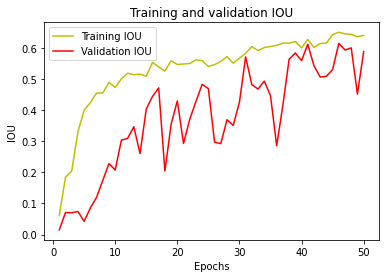

In [ ]:
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5
intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.6490418542704078


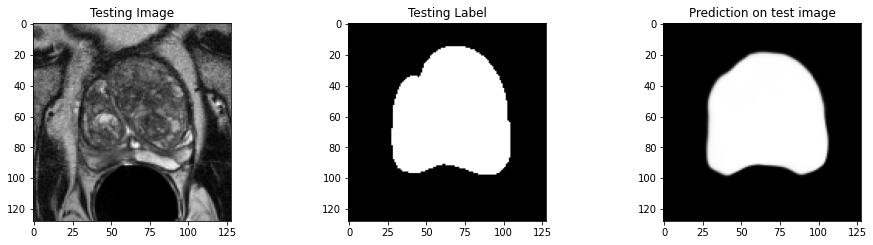

In [ ]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.show()

In [ ]:
model.save('UR.h5')